In [ ]:
# ========== 1. Imports ==========
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc,
    fbeta_score, matthews_corrcoef
)
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import zscore

Mounted at /content/drive


In [ ]:
# ========== 2. Load Dataset ==========
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ML LAB SEM 5/spam_or_not_spam.csv")
df.dropna(subset=['email'], inplace=True)

<class 'pandas.core.frame.DataFrame'>
Index: 2999 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   email   2999 non-null   object 
 1   label   2999 non-null   float64
dtypes: float64(1), object(1)
memory usage: 70.3+ KB
None
label
0.0    2500
1.0     499
Name: count, dtype: int64


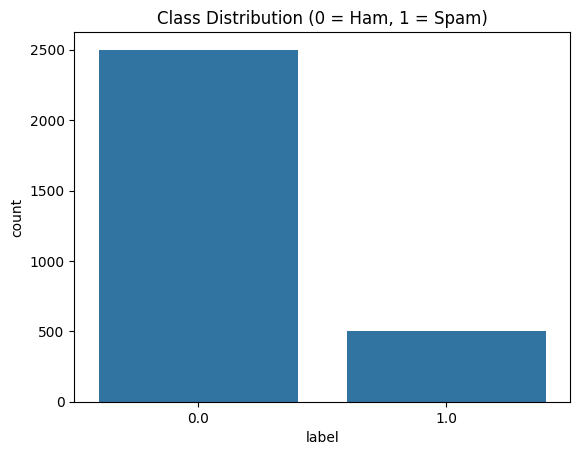

In [ ]:
# ========== 3. EDA ==========
# Fill missing numeric values if any
num_cols = df.select_dtypes(include=[np.number]).columns
if len(num_cols) > 0:
    imputer = SimpleImputer(strategy='mean')
    df[num_cols] = imputer.fit_transform(df[num_cols])

# Remove outliers from numeric columns
if len(num_cols) > 0:
    z_scores = np.abs(zscore(df[num_cols]))
    df = df[(z_scores < 3).all(axis=1)]

print(df.info())
print(df['label'].value_counts())
sns.countplot(x='label', data=df)
plt.title("Class Distribution (0 = Ham, 1 = Spam)")
plt.show()

In [ ]:
# ========== 4. Text Preprocessing ==========
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
X = tfidf.fit_transform(df['email']).toarray()
y = df['label']

# ========== 5. Scaling ==========
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Shape of TF-IDF matrix before scaling:", X.shape)
print("Shape of TF-IDF matrix after scaling:", X_scaled.shape)

# Print first 5 rows before and after scaling
print("\nBefore Scaling (TF-IDF values):")
print(pd.DataFrame(X[:5, :10]))

print("\nAfter Scaling:")
print(pd.DataFrame(X_scaled[:5, :10]))

Shape of TF-IDF matrix before scaling: (2999, 1000)
Shape of TF-IDF matrix after scaling: (2999, 1000)

Before Scaling (TF-IDF values):
          0    1         2    3    4    5    6    7    8    9
0  0.031672  0.0  0.050609  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1  0.000000  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2  0.000000  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3  0.098441  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4  0.000000  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0

After Scaling:
          0        1         2         3         4         5         6  \
0  0.435582 -0.13322  1.980391 -0.126859 -0.126388 -0.179581 -0.112595   
1 -0.454271 -0.13322 -0.180178 -0.126859 -0.126388 -0.179581 -0.112595   
2 -0.454271 -0.13322 -0.180178 -0.126859 -0.126388 -0.179581 -0.112595   
3  2.311546 -0.13322 -0.180178 -0.126859 -0.126388 -0.179581 -0.112595   
4 -0.454271 -0.13322 -0.180178 -0.126859 -0.126388 -0.179581 -0.112595   

          7         8         9

In [ ]:
# ========== 6. Split Data Separately ==========
# For models that require scaled features (KNN, SVM)
X_train_scaled, X_temp_scaled, y_train_scaled, y_temp_scaled = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)
X_val_scaled, X_test_scaled, y_val_scaled, y_test_scaled = train_test_split(
    X_temp_scaled, y_temp_scaled, test_size=0.5, random_state=42, stratify=y_temp_scaled
)

# For models that require unscaled features (Naive Bayes)
X_train_raw, X_temp_raw, y_train_raw, y_temp_raw = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val_raw, X_test_raw, y_val_raw, y_test_raw = train_test_split(
    X_temp_raw, y_temp_raw, test_size=0.5, random_state=42, stratify=y_temp_raw
)

In [ ]:
# ========== 7. Evaluation Helper ==========
def evaluate_model(model, name, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"\n{name} Evaluation:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("F-beta Score (β=0.5):", fbeta_score(y_test, y_pred, beta=0.5))
    print("Matthews Corr Coef:", matthews_corrcoef(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    else:
        y_score = model.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_score)
    plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.2f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.title(f"{name} - ROC Curve")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.grid()
    plt.show()


GaussianNB Evaluation:
Accuracy: 0.9866666666666667
Precision: 0.9726027397260274
Recall: 0.9466666666666667
F1 Score: 0.9594594594594594
F-beta Score (β=0.5): 0.9673024523160763
Matthews Corr Coef: 0.9516069343072303


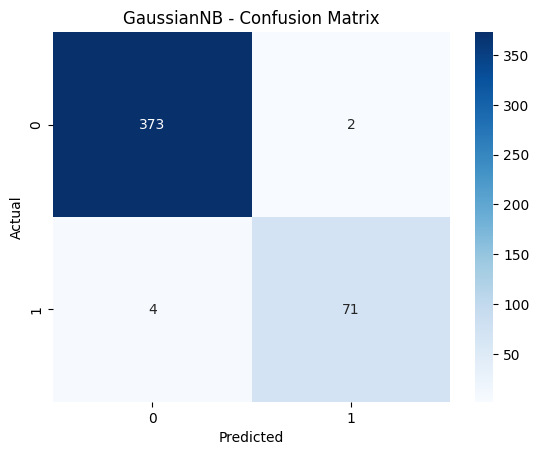

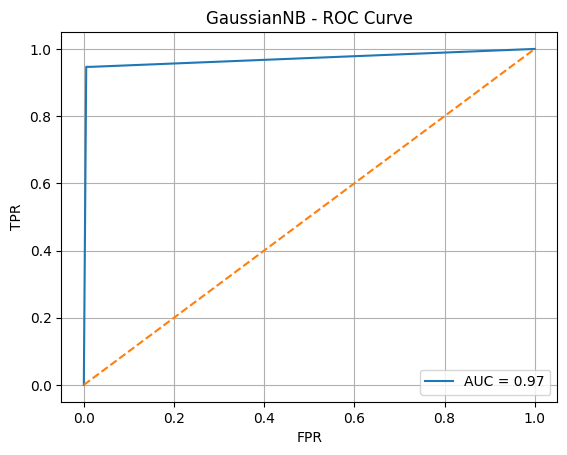


MultinomialNB Evaluation:
Accuracy: 0.9866666666666667
Precision: 0.9859154929577465
Recall: 0.9333333333333333
F1 Score: 0.958904109589041
F-beta Score (β=0.5): 0.9749303621169917
Matthews Corr Coef: 0.9514624328283552


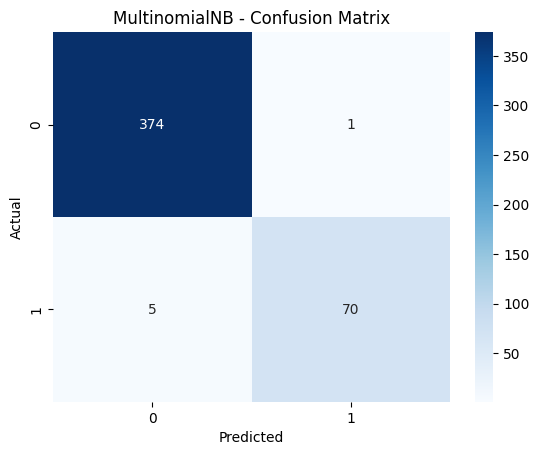

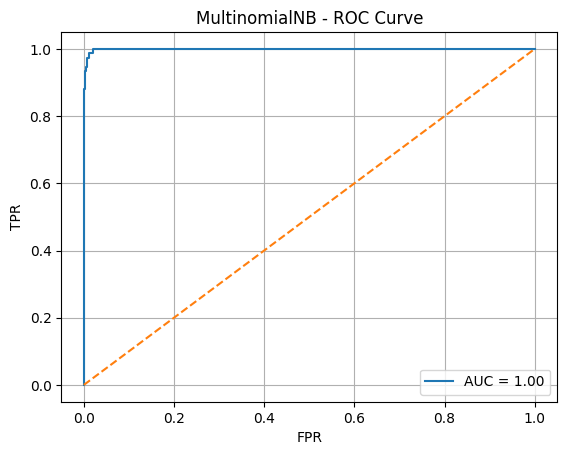


BernoulliNB Evaluation:
Accuracy: 0.9577777777777777
Precision: 0.8888888888888888
Recall: 0.8533333333333334
F1 Score: 0.8707482993197279
F-beta Score (β=0.5): 0.8815426997245179
Matthews Corr Coef: 0.8457800632220621


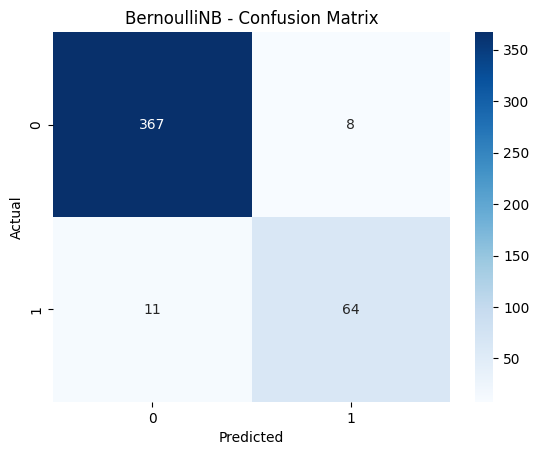

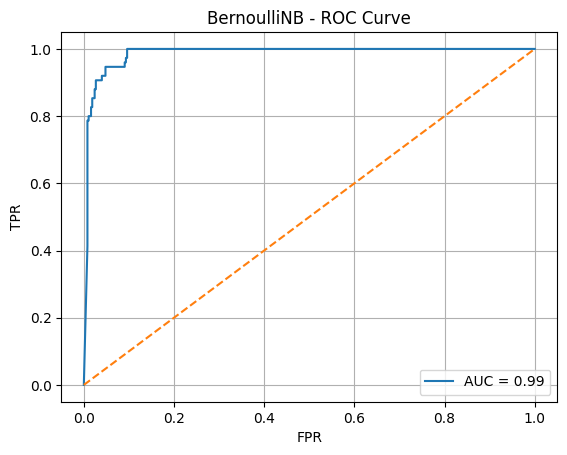

In [ ]:
# ========== 8. Naïve Bayes ==========
for name, model in {
    "GaussianNB": GaussianNB(),
    "MultinomialNB": MultinomialNB(),
    "BernoulliNB": BernoulliNB()
}.items():
    model.fit(X_train_raw, y_train_raw)
    evaluate_model(model, name, X_test_raw, y_test_raw)


KNN (k=1) Evaluation:
Accuracy: 0.7733333333333333
Precision: 0.42011834319526625
Recall: 0.9466666666666667
F1 Score: 0.5819672131147541
F-beta Score (β=0.5): 0.47270306258322237
Matthews Corr Coef: 0.5274139454909135


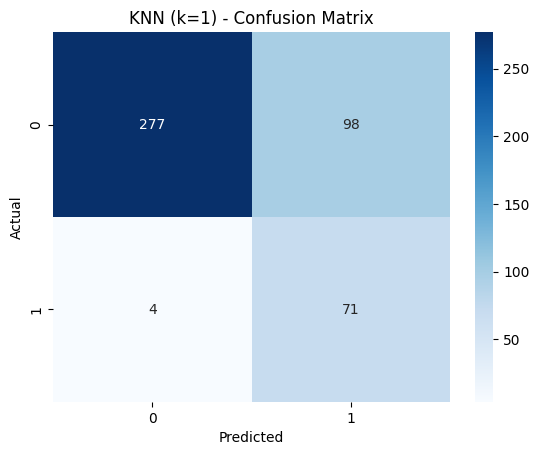

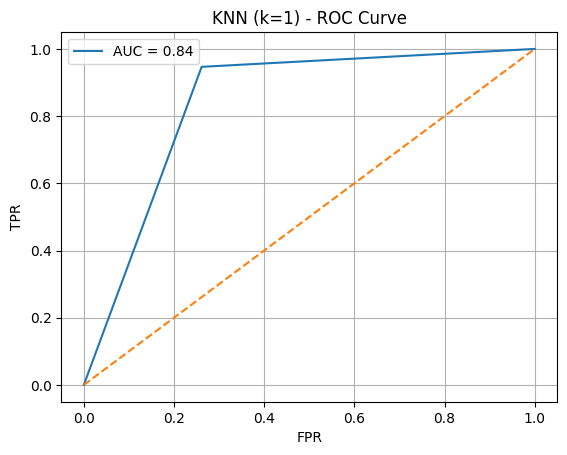


KNN (k=3) Evaluation:
Accuracy: 0.6288888888888889
Precision: 0.30833333333333335
Recall: 0.9866666666666667
F1 Score: 0.46984126984126984
F-beta Score (β=0.5): 0.357487922705314
Matthews Corr Coef: 0.40637772717369386


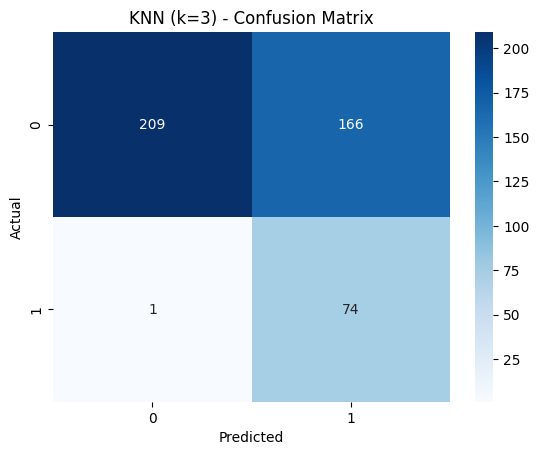

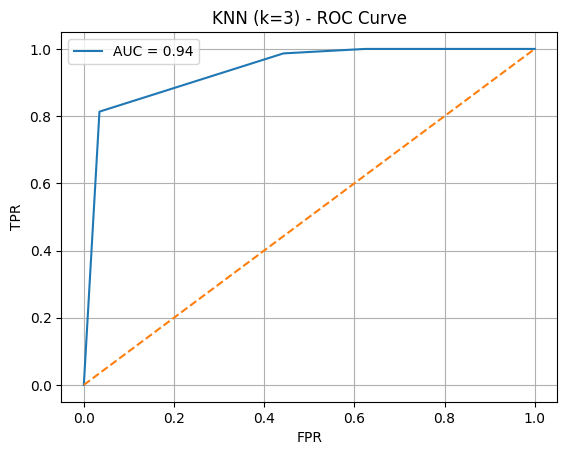


KNN (k=5) Evaluation:
Accuracy: 0.8688888888888889
Precision: 0.5645161290322581
Recall: 0.9333333333333333
F1 Score: 0.7035175879396985
F-beta Score (β=0.5): 0.6129597197898424
Matthews Corr Coef: 0.6583958219651456


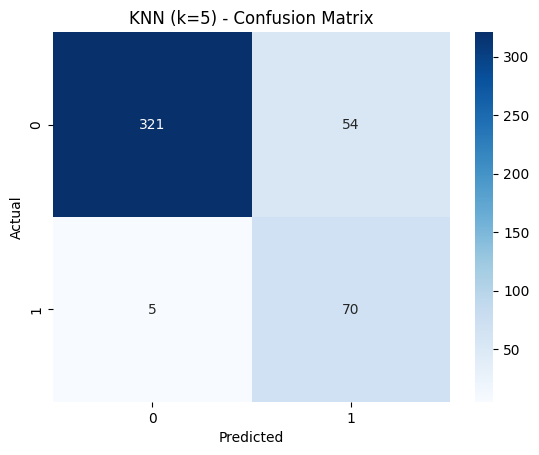

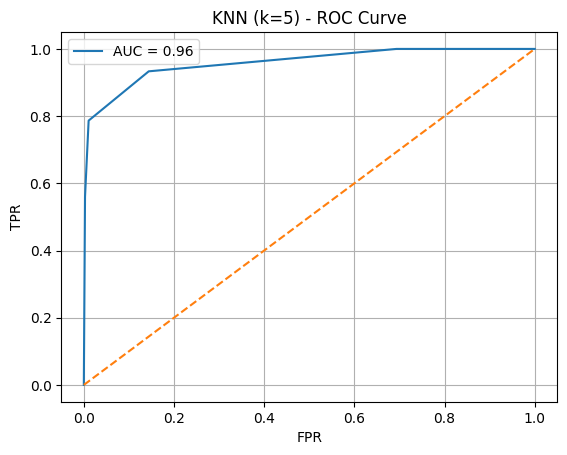


KNN (k=7) Evaluation:
Accuracy: 0.9644444444444444
Precision: 0.9041095890410958
Recall: 0.88
F1 Score: 0.8918918918918919
F-beta Score (β=0.5): 0.8991825613079019
Matthews Corr Coef: 0.8707338237428764


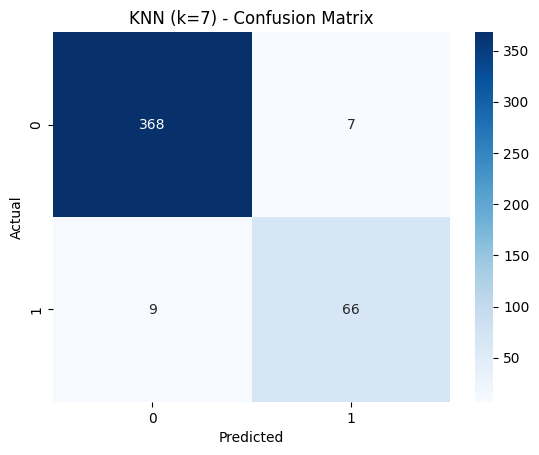

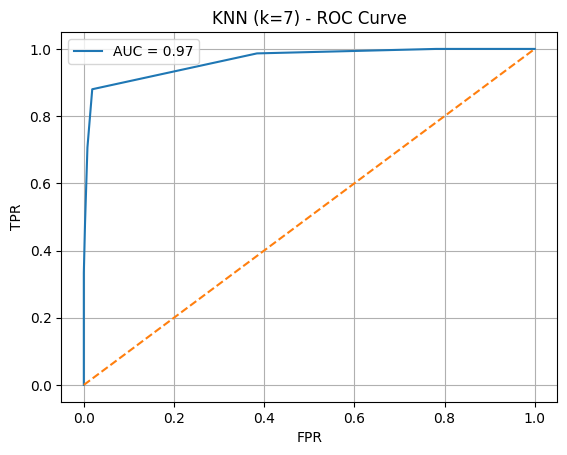


KNN (kd_tree) Evaluation:
Accuracy: 0.8688888888888889
Precision: 0.5645161290322581
Recall: 0.9333333333333333
F1 Score: 0.7035175879396985
F-beta Score (β=0.5): 0.6129597197898424
Matthews Corr Coef: 0.6583958219651456


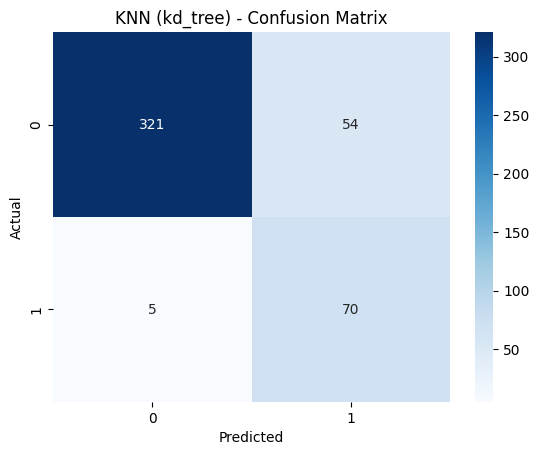

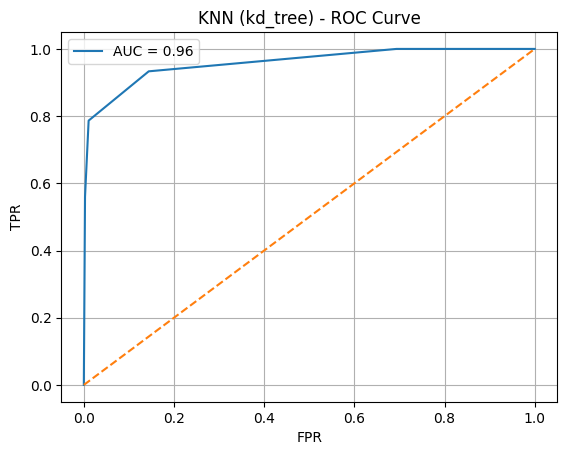


KNN (ball_tree) Evaluation:
Accuracy: 0.8688888888888889
Precision: 0.5645161290322581
Recall: 0.9333333333333333
F1 Score: 0.7035175879396985
F-beta Score (β=0.5): 0.6129597197898424
Matthews Corr Coef: 0.6583958219651456


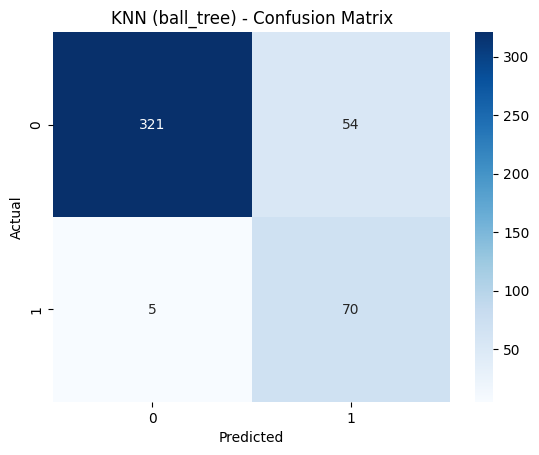

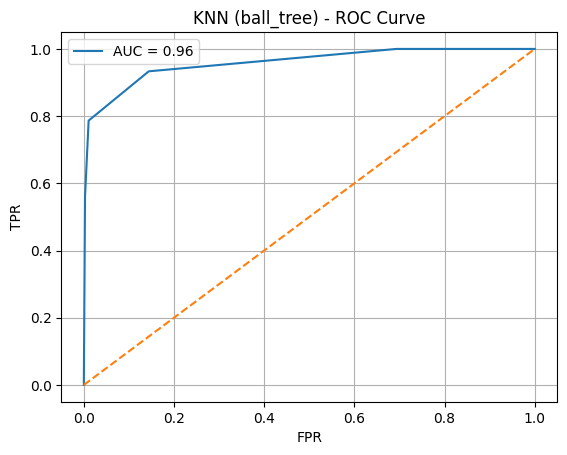

In [ ]:
# ========== 9. KNN ==========
for k in [1, 3, 5, 7]:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_scaled, y_train_scaled)
    evaluate_model(model, f"KNN (k={k})", X_test_scaled, y_test_scaled)

for algo in ["kd_tree", "ball_tree"]:
    model = KNeighborsClassifier(algorithm=algo)
    model.fit(X_train_scaled, y_train_scaled)
    evaluate_model(model, f"KNN ({algo})", X_test_scaled, y_test_scaled)


SVM (Linear) Evaluation:
Accuracy: 0.98
Precision: 0.9230769230769231
Recall: 0.96
F1 Score: 0.9411764705882353
F-beta Score (β=0.5): 0.9302325581395349
Matthews Corr Coef: 0.9293931956705993


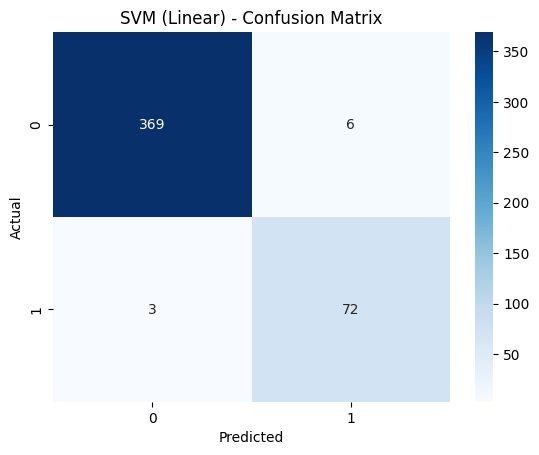

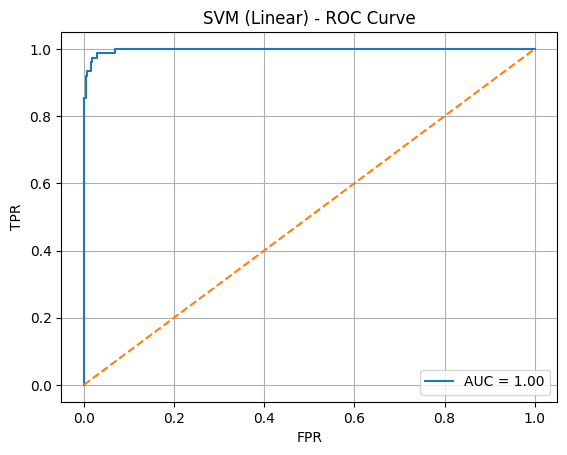


SVM (Polynomial) Evaluation:
Accuracy: 0.9044444444444445
Precision: 1.0
Recall: 0.4266666666666667
F1 Score: 0.5981308411214953
F-beta Score (β=0.5): 0.7881773399014779
Matthews Corr Coef: 0.6186882248897461


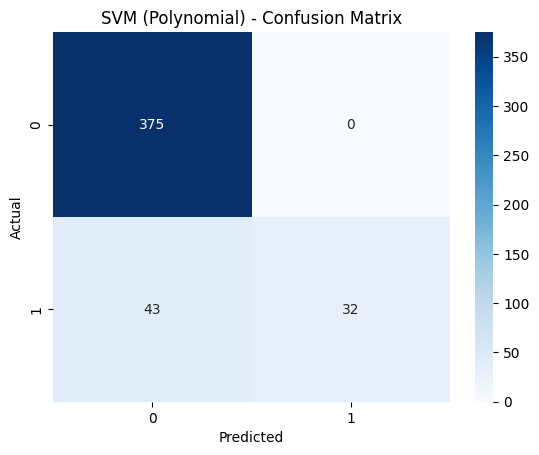

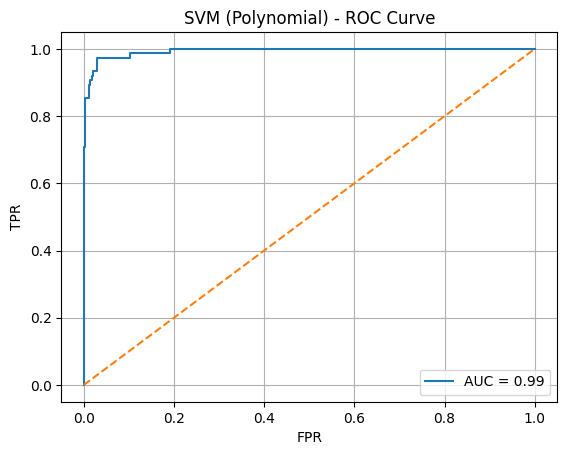


SVM (RBF) Evaluation:
Accuracy: 0.9844444444444445
Precision: 1.0
Recall: 0.9066666666666666
F1 Score: 0.951048951048951
F-beta Score (β=0.5): 0.9798270893371758
Matthews Corr Coef: 0.9434258614331825


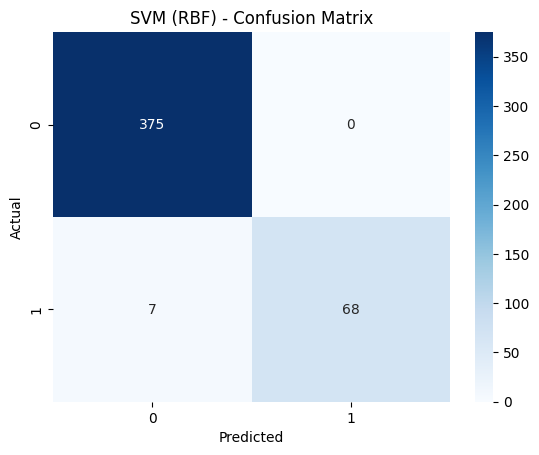

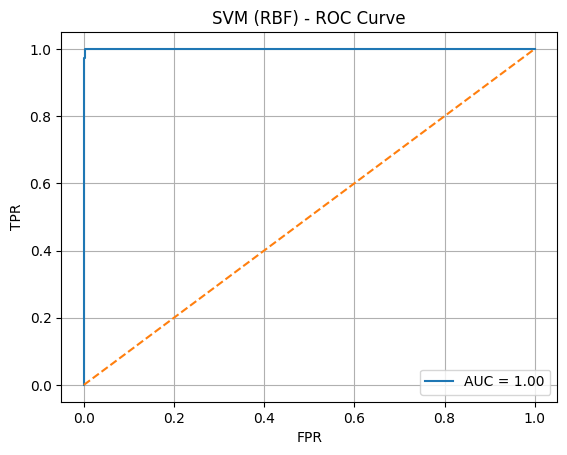


SVM (Sigmoid) Evaluation:
Accuracy: 0.98
Precision: 0.9852941176470589
Recall: 0.8933333333333333
F1 Score: 0.9370629370629371
F-beta Score (β=0.5): 0.9654178674351584
Matthews Corr Coef: 0.9267771697608322


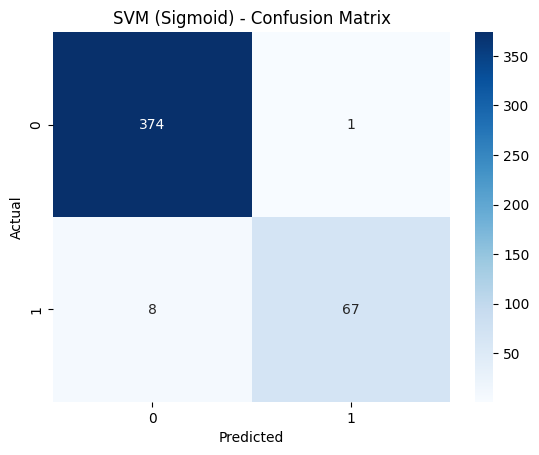

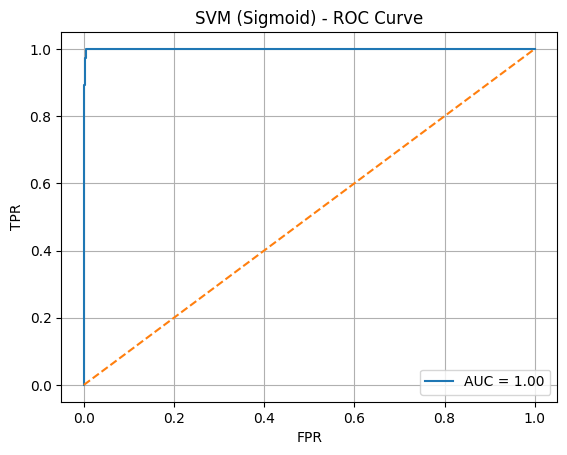

In [ ]:
# ========== 10. SVM ==========
kernels = {
    "Linear": SVC(kernel='linear', C=1, probability=True),
    "Polynomial": SVC(kernel='poly', C=1, degree=3, gamma='auto', probability=True),
    "RBF": SVC(kernel='rbf', C=1, gamma='scale', probability=True),
    "Sigmoid": SVC(kernel='sigmoid', C=1, gamma='auto', probability=True)
}
for name, model in kernels.items():
    model.fit(X_train_scaled, y_train_scaled)
    evaluate_model(model, f"SVM ({name})", X_test_scaled, y_test_scaled)

In [ ]:
# ========== 11. 5-Fold Cross Validation ==========
# Common CV strategy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def evaluate_cv(model, name, X_data, y_data):
    print(f"\n5-Fold Cross Validation: {name}")
    scores = {
        "Accuracy": cross_val_score(model, X_data, y_data, cv=skf, scoring='accuracy').mean(),
        "Precision": cross_val_score(model, X_data, y_data, cv=skf, scoring='precision').mean(),
        "Recall": cross_val_score(model, X_data, y_data, cv=skf, scoring='recall').mean(),
        "F1 Score": cross_val_score(model, X_data, y_data, cv=skf, scoring='f1').mean()
    }
    for metric, score in scores.items():
        print(f"{metric}: {score:.4f}")

# ===========================
# Naive Bayes
# ===========================
for name, model in {
    "GaussianNB": GaussianNB(),
    "MultinomialNB": MultinomialNB(),
    "BernoulliNB": BernoulliNB()
}.items():
    evaluate_cv(model, name, X, y)

# ===========================
# KNN
# ===========================
for k in [1, 3, 5, 7]:
    model = KNeighborsClassifier(n_neighbors=k)
    evaluate_cv(model, f"KNN (k={k})", X_scaled, y)

for algo in ["kd_tree", "ball_tree"]:
    model = KNeighborsClassifier(algorithm=algo)
    evaluate_cv(model, f"KNN ({algo})", X_scaled, y)

# ===========================
# SVM Kernels
# ===========================
svm_kernels = {
    "SVM Linear": SVC(kernel='linear', C=1, probability=True),
    "SVM Polynomial": SVC(kernel='poly', C=1, degree=3, gamma='auto', probability=True),
    "SVM RBF": SVC(kernel='rbf', C=1, gamma='scale', probability=True),
    "SVM Sigmoid": SVC(kernel='sigmoid', C=1, gamma='auto', probability=True)
}
for name, model in svm_kernels.items():
    evaluate_cv(model, name, X_scaled, y)


5-Fold Cross Validation: GaussianNB
Accuracy: 0.9647
Precision: 0.9099
Recall: 0.8758
F1 Score: 0.8917

5-Fold Cross Validation: MultinomialNB
Accuracy: 0.9770
Precision: 0.9754
Recall: 0.8839
F1 Score: 0.9270

5-Fold Cross Validation: BernoulliNB
Accuracy: 0.9507
Precision: 0.8618
Recall: 0.8398
F1 Score: 0.8497

5-Fold Cross Validation: KNN (k=1)
Accuracy: 0.8056
Precision: 0.4569
Recall: 0.8858
F1 Score: 0.6025

5-Fold Cross Validation: KNN (k=3)
Accuracy: 0.7619
Precision: 0.4659
Recall: 0.9139
F1 Score: 0.5922

5-Fold Cross Validation: KNN (k=5)
Accuracy: 0.9196
Precision: 0.7654
Recall: 0.8178
F1 Score: 0.7759

5-Fold Cross Validation: KNN (k=7)
Accuracy: 0.9423
Precision: 0.9380
Recall: 0.7036
F1 Score: 0.8001

5-Fold Cross Validation: KNN (kd_tree)
Accuracy: 0.9193
Precision: 0.7646
Recall: 0.8178
F1 Score: 0.7754

5-Fold Cross Validation: KNN (ball_tree)
Accuracy: 0.9196
Precision: 0.7654
Recall: 0.8178
F1 Score: 0.7759

5-Fold Cross Validation: SVM Linear
Accuracy: 0.9660
Pr

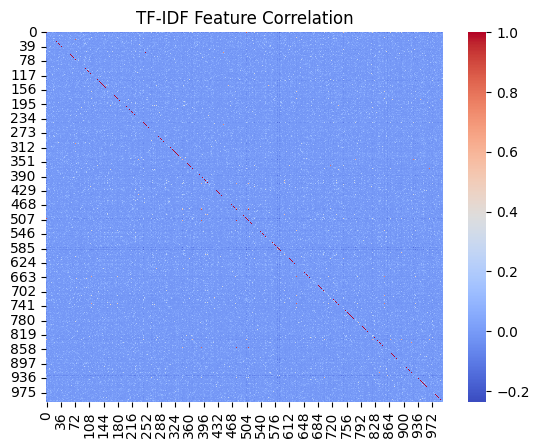

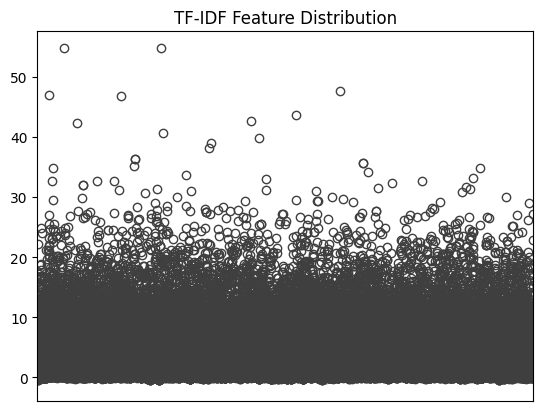

In [ ]:
# ========== 12. Visualizations (Scaled TF-IDF) ==========
sns.heatmap(pd.DataFrame(X_scaled).corr(), cmap='coolwarm')
plt.title("TF-IDF Feature Correlation")
plt.show()

sns.boxplot(data=pd.DataFrame(X_scaled))
plt.xticks([])
plt.title("TF-IDF Feature Distribution")
plt.show()